In [1]:
import sys
sys.path.insert(0, '../Utilities/')
import os

from scipy.interpolate import griddata
from pyDOE import lhs
from plotting import newfig, savefig
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io
from pysr import PySRRegressor
import sympy 
import pandas as pd

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [2]:

# Carga los archivos .xlsx
file1 = '../DataExperiments/WT_in_LB_data_s1.XLSX'
file2 = '../DataExperiments/different_conditions_data_s2.XLSX'

# Lee las hojas de los archivos
df1 = pd.read_excel(file1, engine='openpyxl')  # Especifica la hoja si es necesario: sheet_name='nombre_hoja'
df2 = pd.read_excel(file2, engine='openpyxl')

# Cambiar la fila 0 a la nueva cabecera
df2.columns = df2.iloc[0]  # Establecer la primera fila como nueva cabecera
df2 = df2[1:]  # Eliminar la primera fila

# Reiniciar los índices (opcional, si quieres que empiece desde 0)
df2 = df2.reset_index(drop=True)

# Muestra los DataFrames
print("Archivo 1:")
display(df1)

print("Archivo 2:")
display(df2)


Archivo 1:


,Cycle Nr.,Time [s],Temp. [°C],G4,G5,G6,G7,G8,G9,G10,G11,G12,H1,H2,H3,H4,H5,H6
0,1,0.0,30.8,0.0922,0.0928,0.0928,0.0931,0.0928,0.0927,0.0916,0.0921,0.0911,0.0936,0.0925,0.0918,0.0929,0.0931,0.0931
1,2,678.6,30.7,0.0951,0.0957,0.0959,0.0959,0.0957,0.0953,0.0947,0.0951,0.0941,0.0970,0.0958,0.0951,0.0963,0.0963,0.0962
2,3,1357.1,30.4,0.0951,0.0958,0.0957,0.0960,0.0958,0.0954,0.0947,0.0951,0.0943,0.0971,0.0959,0.0952,0.0965,0.0964,0.0963
3,4,2035.7,30.2,0.0955,0.0962,0.0961,0.0965,0.0964,0.0958,0.0950,0.0957,0.0947,0.0975,0.0964,0.0957,0.0969,0.0969,0.0969
4,5,2714.2,30.0,0.0960,0.0969,0.0965,0.0968,0.0968,0.0964,0.0956,0.0963,0.0953,0.0981,0.0969,0.0961,0.0974,0.0973,0.0973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,495,335199.8,30.8,0.8186,0.8214,0.8188,0.8198,0.8221,0.8201,0.8296,0.8418,0.8292,0.4360,0.7711,0.8043,0.8181,0.8181,0.8153
495,496,335878.3,30.9,0.8184,0.8222,0.8185,0.8178,0.8201,0.8182,0.8277,0.8379,0.8274,0.4379,0.7729,0.8038,0.8198,0.8180,0.8154
496,497,336556.8,30.8,0.8183,0.8222,0.8169,0.8204,0.8214,0.8186,0.8287,0.8409,0.8289,0.4304,0.7719,0.8040,0.8187,0.8172,0.8154
497,498,337235.3,30.8,0.8172,0.8211,0.8194,0.8206,0.8227,0.8201,0.8303,0.8417,0.8280,0.4321,0.7717,0.8043,0.8194,0.8173,0.8143


Archivo 2:


,Cycle Nr.,Time [s],Temp. [°C],A1,A2,A3,A4,A5,A6,A7,...,H2,H3,H4,H5,H6,H7,H8,H9,H10,H11
0,1,0,30,0.0929,0.0971,0.0948,0.0961,0.0939,0.0934,0.0938,...,0.0913,0.0914,0.0924,0.0916,0.0925,0.0921,0.092,0.093,0.0927,0.093
1,2,678.6,30.5,0.0925,0.0962,0.0946,0.0953,0.0935,0.0931,0.0933,...,0.0913,0.0916,0.0926,0.092,0.0914,0.0921,0.0921,0.0931,0.0932,0.0925
2,3,1357.2,30.1,0.0926,0.0962,0.095,0.0954,0.0936,0.0932,0.0932,...,0.0916,0.0917,0.0927,0.0918,0.0917,0.0922,0.0923,0.0932,0.0932,0.0927
3,4,2035.8,30,0.0928,0.0981,0.0949,0.0956,0.0937,0.0934,0.0934,...,0.092,0.0921,0.0931,0.0922,0.0922,0.0928,0.0926,0.0936,0.0937,0.093
4,5,2714.4,30.3,0.0933,0.0985,0.0953,0.096,0.0942,0.0939,0.0938,...,0.0925,0.0927,0.0937,0.0928,0.093,0.0933,0.0933,0.0943,0.0944,0.0938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,338,228685.2,29.9,0.5954,0.6453,0.6513,0.6593,0.6599,0.6576,0.5901,...,0.0926,0.0926,0.0935,0.0924,0.0949,1.0018,0.9769,0.9848,0.9871,0.9972
338,339,229363.7,29.8,0.5937,0.6448,0.6495,0.6568,0.6572,0.6564,0.5898,...,0.0926,0.0927,0.0934,0.0926,0.0953,1.0017,0.98,0.9857,0.9868,0.9976
339,340,230042.3,29.9,0.5923,0.6429,0.6487,0.6575,0.6589,0.6572,0.5889,...,0.0925,0.0925,0.0933,0.0923,0.0947,1.0009,0.9758,0.9833,0.9846,0.9963
340,341,230720.9,30.3,0.5912,0.6419,0.6484,0.6568,0.657,0.6548,0.5888,...,0.0923,0.0924,0.0932,0.0921,0.0942,1.0004,0.9763,0.9843,0.9845,0.9981


In [3]:
df1.iloc[:, 3:]

,G4,G5,G6,G7,G8,G9,G10,G11,G12,H1,H2,H3,H4,H5,H6
0,0.0922,0.0928,0.0928,0.0931,0.0928,0.0927,0.0916,0.0921,0.0911,0.0936,0.0925,0.0918,0.0929,0.0931,0.0931
1,0.0951,0.0957,0.0959,0.0959,0.0957,0.0953,0.0947,0.0951,0.0941,0.0970,0.0958,0.0951,0.0963,0.0963,0.0962
2,0.0951,0.0958,0.0957,0.0960,0.0958,0.0954,0.0947,0.0951,0.0943,0.0971,0.0959,0.0952,0.0965,0.0964,0.0963
3,0.0955,0.0962,0.0961,0.0965,0.0964,0.0958,0.0950,0.0957,0.0947,0.0975,0.0964,0.0957,0.0969,0.0969,0.0969
4,0.0960,0.0969,0.0965,0.0968,0.0968,0.0964,0.0956,0.0963,0.0953,0.0981,0.0969,0.0961,0.0974,0.0973,0.0973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,0.8186,0.8214,0.8188,0.8198,0.8221,0.8201,0.8296,0.8418,0.8292,0.4360,0.7711,0.8043,0.8181,0.8181,0.8153
495,0.8184,0.8222,0.8185,0.8178,0.8201,0.8182,0.8277,0.8379,0.8274,0.4379,0.7729,0.8038,0.8198,0.8180,0.8154
496,0.8183,0.8222,0.8169,0.8204,0.8214,0.8186,0.8287,0.8409,0.8289,0.4304,0.7719,0.8040,0.8187,0.8172,0.8154
497,0.8172,0.8211,0.8194,0.8206,0.8227,0.8201,0.8303,0.8417,0.8280,0.4321,0.7717,0.8043,0.8194,0.8173,0.8143


In [4]:
c=-1
P_exp=np.array(df1.iloc[:, 3:].drop('H1',axis=1))[:c]
T_exp=np.array(df1['Time [s]'])[:c]

T_max=max(T_exp)
T_exp=T_exp/max(T_exp)
N_exp=P_exp.shape[1]
N_exp,T_max

(14, 337235.3)

In [5]:
P_exp.shape[0]*P_exp.shape[1]

6972

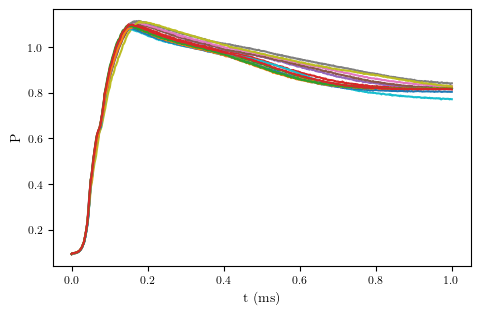

In [6]:
for i in range(N_exp):
    plt.plot(T_exp,P_exp[:, i])
plt.xlabel('t (ms)')
plt.ylabel('P ')
plt.show()

In [7]:
N_f = 300 # Number of residual point
N_d = 1000 #Number of data

P_star = P_exp.T.flatten().reshape([-1,1])
T_star = np.tile(T_exp,N_exp).reshape([-1,1])

# Doman bounds
lb = T_star.min(0)
ub = T_star.max(0) 

# Initial Condition
xx1 = T_star[::len(T_exp)]
uu1 = P_star[::len(T_exp)]

# Additional data
idx = np.random.choice(P_star.shape[0], N_d-len(uu1), replace=False)
xxd = T_star[idx]
uud = P_star[idx]

T_u_train = np.concatenate((xx1,xxd)).reshape([-1,1])
p_train = np.concatenate((uu1,uud)).reshape([-1,1])

T_f_train = lb + (ub-lb)*lhs(1, N_f)

T_u_train_tf = tf.convert_to_tensor(T_u_train, dtype=tf.float32)
p_train_tf =   tf.convert_to_tensor(p_train, dtype=tf.float32)
T_f_train_tf = tf.convert_to_tensor(T_f_train, dtype=tf.float32)
P_star_tf = tf.convert_to_tensor(P_star, dtype=tf.float32)

2024-10-24 13:08:42.566046: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2024-10-24 13:08:42.566381: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cublas64_11.dll'; dlerror: cublas64_11.dll not found
2024-10-24 13:08:42.566656: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cublasLt64_11.dll'; dlerror: cublasLt64_11.dll not found
2024-10-24 13:08:42.566918: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cufft64_10.dll'; dlerror: cufft64_10.dll not found
2024-10-24 13:08:42.567165: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'curand64_10.dll'; dlerror: curand64_10.dll not found
2024-10-24 13:08:42.567413: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dyna

In [8]:
np.random.seed(seed=1234)
tf.random.set_seed(1234)
tf.config.experimental.enable_tensor_float_32_execution(False)
#os.environ[‘TF_ENABLE_AUTO_MIXED_PRECISION’] = ‘1’



# Initalization of Network
def hyper_initial(size):
    in_dim = size[0]
    out_dim = size[1]
    std = np.sqrt(2.0/(in_dim + out_dim))
    return tf.Variable(tf.random.truncated_normal(shape=size, stddev = std))

# Neural Network 
def DNN(X, W, b):
    A = 2.0*(X - lb)/(ub - lb) - 1.0
    L = len(W)
    for i in range(L-1):
        A = tf.tanh(tf.add(tf.matmul(A, W[i]), b[i]))
    Y = tf.add(tf.matmul(A, W[-1]), b[-1])
    return Y

def train_vars(W, b):
    return W + b 

def train_vars_total(W, b, lambda_r, lambda_b):
    return W + b + lambda_r + lambda_b

def net(t, w, b):
    p = DNN(t, w, b)
    return p

def loss_weight(N_r, N_b):
    alpha_b = tf.Variable(tf.reshape(tf.repeat(1000.0, N_b), (N_b, -1))) 
    alpha_r = tf.Variable(tf.ones(shape=[N_r, 1]), dtype=tf.float32)
    return alpha_r, alpha_b

#@tf.function(jit_compile=True)
@tf.function()
def net_f(t, W_p, b_p):
    with tf.GradientTape(persistent=True) as tape1:
        tape1.watch([t])
        u=net(t, W_p, b_p)
        lnp=u[:,0:1]
        r=u[:,1:2]
        p=tf.exp(lnp)

    p_t = tape1.gradient(p, t) 
    f = p_t - (r*p)
    
    return f


#@tf.function()
@tf.function()
def train_step(W_p, b_p, X_u_train_tf, p_train_tf, X_f_train_tf, lambda_r, lambda_b, opt):
    
    t_u = X_u_train_tf
    t_f = X_f_train_tf

    with tf.GradientTape(persistent=True) as tape:
        tape.watch([W_p, b_p, lambda_r, lambda_b])
        u_nn = net(t_u, W_p, b_p) 
        lnp=u_nn[:,0:1]
        p_nn=tf.exp(lnp)
        f = net_f(t_f, W_p, b_p)

        loss_p = tf.square(lambda_b*(p_nn - p_train_tf))
        loss_f= tf.square(lambda_r*f) 
        loss =  tf.reduce_mean(loss_p) + tf.reduce_mean(loss_f)
    grads_p = tape.gradient(loss, train_vars(W_p, b_p))
    grads_u = tape.gradient(loss, lambda_r)
    grads_b = tape.gradient(loss, lambda_b)
    opt.apply_gradients(zip(grads_p, train_vars(W_p, b_p)))
    opt.apply_gradients(zip([-grads_u], [lambda_r]))
    opt.apply_gradients(zip([-grads_b], [lambda_b]))
   
    return loss, tf.reduce_mean(loss_p), tf.reduce_mean(loss_f)



layers = [1, 50, 50, 2]

L = len(layers)
W_p = [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)] 
b_p = [tf.Variable(tf.zeros([1, layers[l]])) for l in range(1, L)]

# layers = [2, 50, 50, 1]


# W_phi = [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)] 
# b_phi = [tf.Variable(tf.zeros([1, layers[l]])) for l in range(1, L)]

lambda_r, lambda_b = loss_weight(N_f, N_d)
# m = [tf.Variable(tf.ones([1,1]), dtype=tf.float32)]

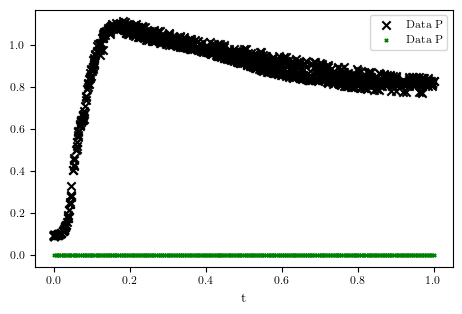

In [9]:
plt.scatter(T_u_train, p_train, marker='x', color='black',label='Data P')
plt.scatter(T_f_train_tf, np.zeros_like(T_f_train_tf), s=5, marker='x', color='green',label='Data P')


plt.legend()
plt.xlabel('t')
# plt.ylabel('P')
# plt.savefig('figures/P_phi.pdf')
plt.show()

In [246]:
lambda_b

<tf.Variable 'Variable:0' shape=(1000, 1) dtype=float32, numpy=
array([[1069.762  ],
       [1069.8337 ],
       [1069.8337 ],
       [1069.8683 ],
       [1069.8337 ],
       [1069.8219 ],
       [1069.69   ],
       [1069.7506 ],
       [1069.6268 ],
       [1069.7977 ],
       [1069.7153 ],
       [1069.8456 ],
       [1069.8683 ],
       [1069.8683 ],
       [1077.0922 ],
       [1074.0895 ],
       [1049.353  ],
       [1067.042  ],
       [1067.4083 ],
       [1075.0731 ],
       [1075.4795 ],
       [1064.3622 ],
       [1071.7167 ],
       [1072.1168 ],
       [1072.4229 ],
       [1072.812  ],
       [1045.276  ],
       [1022.7746 ],
       [1064.6823 ],
       [1043.1498 ],
       [1043.9397 ],
       [1078.1312 ],
       [1062.6744 ],
       [1040.1116 ],
       [1077.9841 ],
       [1070.5728 ],
       [1070.8032 ],
       [1077.7976 ],
       [1073.6941 ],
       [1071.7599 ],
       [1069.578  ],
       [1041.1066 ],
       [1073.5906 ],
       [1074.298  ],
       [1071

In [10]:
lr = 1e-3
# Nmax = 15000
# Nmax = 30000
Nmax=2*10**5
# Nmax = 10**5
Nmax = 80000



optimizer = tf.optimizers.Adam(learning_rate=lr)

start_time = time.time()
n=0
loss = []
loss_d = []
loss_fis = []

while n <= Nmax:
    loss_, loss_p, loss_f = train_step(W_p, b_p, T_u_train_tf, p_train_tf, T_f_train_tf, lambda_r, lambda_b, optimizer)
    loss.append(loss_)
    loss_d.append(loss_p)
    loss_fis.append(loss_f)


    if n % 10 == 0:
        print(f"Iteration is: {n}")
        print(f"Total loss is: {loss_}")

        print(f"Data loss is: {loss_p}")
        print(f"Physicial loss of p is: {loss_f}")

    n+=1

elapsed = time.time() - start_time                
print('Training time: %.4f' % (elapsed))

Iteration is: 0
Total loss is: 155766.65625
Data loss is: 155765.890625
Physicial loss of p is: 0.7687333226203918
Iteration is: 10
Total loss is: 48097.109375
Data loss is: 48097.0390625
Physicial loss of p is: 0.07199704647064209
Iteration is: 20
Total loss is: 52630.00390625
Data loss is: 52629.859375
Physicial loss of p is: 0.1428314745426178
Iteration is: 30
Total loss is: 47852.86328125
Data loss is: 47852.86328125
Physicial loss of p is: 0.001800341997295618
Iteration is: 40
Total loss is: 46017.24609375
Data loss is: 46017.234375
Physicial loss of p is: 0.010516428388655186
Iteration is: 50
Total loss is: 45941.78515625
Data loss is: 45941.76171875
Physicial loss of p is: 0.021932000294327736
Iteration is: 60
Total loss is: 45774.76171875
Data loss is: 45774.7578125
Physicial loss of p is: 0.004855660255998373
Iteration is: 70
Total loss is: 45594.59765625
Data loss is: 45594.5859375
Physicial loss of p is: 0.010170822963118553
Iteration is: 80
Total loss is: 45533.1328125
Data

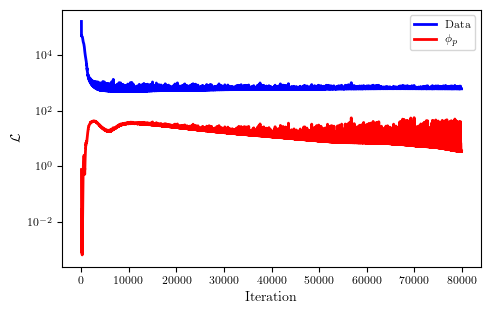

In [11]:
it = np.arange(0,Nmax, 1)
loss_list = [loss[i].numpy() for i in range(0,Nmax)]
loss_data_list = [loss_d[i].numpy() for i in range(0,Nmax)]

loss_phi_list = [loss_fis[i].numpy() for i in range(0,Nmax)]



plt.semilogy(it, np.asarray(loss_data_list), 'b-', linewidth = 2, label = 'Data')  
plt.semilogy(it, np.asarray(loss_phi_list), 'r-', linewidth = 2, label = '$\phi_p$')       


plt.xlabel('Iteration')
plt.ylabel('$\mathcal{L}$')  
plt.legend()  
# plt.savefig('figures/loss_phi.pdf')
plt.show()

In [12]:
def predict(X_star_tf, w, b):
    u_pred = net(X_star_tf, w, b)
    return u_pred

## Evaluating total function
T_star_tf = tf.convert_to_tensor(T_star[:len(T_exp)], dtype=tf.float32)    
u_pred = predict(T_star_tf, W_p, b_p)

# ## Evaluating unknown function
lnp=u_pred[:,0:1]
p=tf.exp(lnp)
r=u_pred[:,1:2]
phi_p = r*p


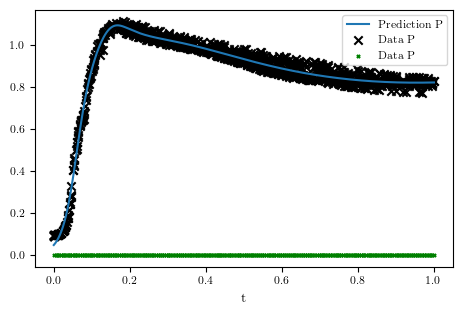

In [13]:
plt.plot(T_star_tf, p, label='Prediction P')


# for i in range(N_exp):
#     plt.plot(T_star[i*len(T_exp):(i+1)*len(T_exp)],P_star[i*len(T_exp):(i+1)*len(T_exp)],linestyle=':')

plt.scatter(T_u_train, p_train, marker='x', color='black',label='Data P')
plt.scatter(T_f_train_tf, np.zeros_like(T_f_train_tf), s=5, marker='x', color='green',label='Data P')


plt.legend()
plt.xlabel('t')
# plt.ylabel('P')
# plt.savefig('figures/P_phi.pdf')
plt.show()

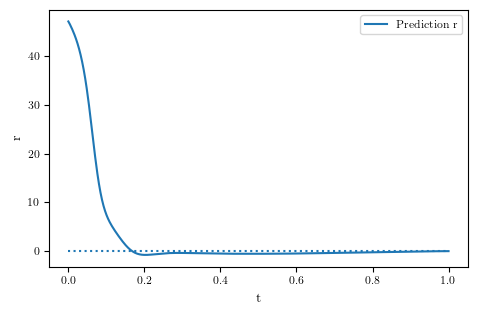

In [14]:

plt.plot(T_star_tf, r, label='Prediction r')
plt.hlines(0,0,1, linestyle=':')

# for i in range(N_exp):
#     plt.plot(T_star[i*len(T_exp):(i+1)*len(T_exp)],P_star[i*len(T_exp):(i+1)*len(T_exp)],linestyle=':')

# plt.scatter(T_u_train, p_train, marker='x', color='black',label='Data P')

plt.legend()
# plt.yscale('log')
# plt.xscale('log')


plt.xlabel('t')
plt.ylabel('r')
# plt.savefig('figures/P_phi.pdf')
plt.show()

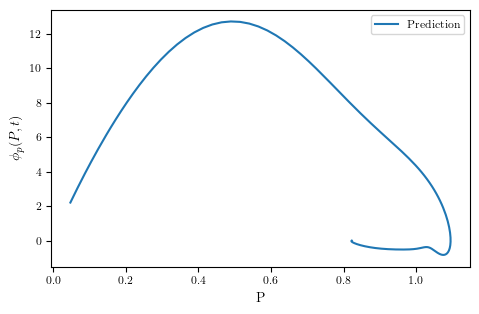

In [15]:
plt.plot(p, phi_p, label='Prediction')
# plt.plot(u_pred[:,1:2], phi_pred, label='Prediction')

# plt.scatter(X_u_train, u_train, marker='x', color='black',label='Data')
# plt.scatter(X_f_train, np.zeros(len(X_f_train)), marker='x')
plt.legend()
plt.xlabel('P')
plt.ylabel('$\phi_p(P, t)$')
# plt.savefig('figures/phi.pdf')
plt.show()

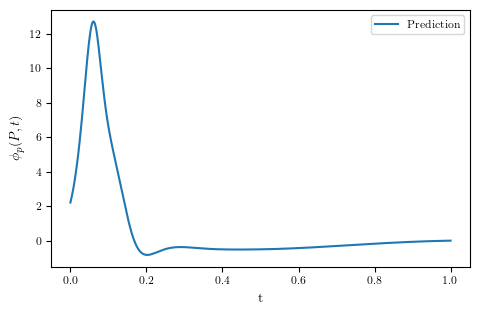

In [16]:
plt.plot(T_star_tf, phi_p, label='Prediction')
# plt.plot(u_pred[:,1:2], phi_pred, label='Prediction')

# plt.scatter(X_u_train, u_train, marker='x', color='black',label='Data')
# plt.scatter(X_f_train, np.zeros(len(X_f_train)), marker='x')
plt.legend()
plt.xlabel('t')
plt.ylabel('$\phi_p(P, t)$')
# plt.savefig('figures/phi.pdf')
plt.show()

In [17]:
Nt=10000
T_int=np.zeros(Nt)
P_int=np.zeros(Nt)
R_int=np.zeros(Nt)


dt=0.0001

T_int[0]=0
for i in range(1,Nt):
    T_int[i]=T_int[i-1]+dt
    
P_int[0]=np.array(p[0]) #Initial conditions
R_int=predict(tf.convert_to_tensor(T_int.reshape([-1,1]), dtype=tf.float32), W_p, b_p)[:,1:2]

for i in range(1,Nt):
    P_int[i]=P_int[i-1]+R_int[i-1]*P_int[i-1]*dt


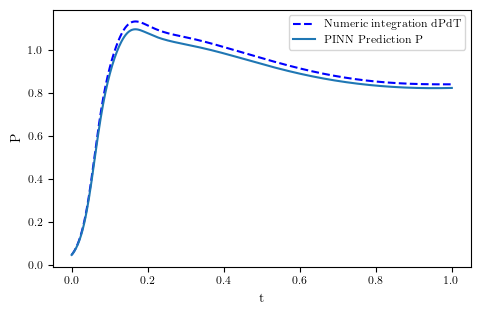

In [18]:
plt.plot(T_int, P_int, color='blue', linestyle='--', label='Numeric integration dPdT')
# plt.plot(T_int, R_int, color='blue', linestyle='--', label='Numeric integration dPdT')

# plt.plot(T_int, R_int, color='orange', linestyle='--', label='Numeric integration dSdT')


plt.plot(T_star_tf, p, label='PINN Prediction P')
# plt.plot(T_star_tf, r, label='PINN Prediction S')
plt.xlabel('t')
plt.ylabel('P')
plt.legend()
plt.show()

# Symbolic Regresion

In [ ]:
# # Create and train the PySR model
# model_phi = PySRRegressor(
#     niterations=1000,
#     binary_operators=["+", "/", "*"],
#     unary_operators=["exp"],
#     # unary_operators=["inv(x) = 1/x"],
#     # extra_sympy_mappings={"inv": lambda x: 1 / x},
#     # constraints={"^": (3, 3)},
#     # constraints={"*": (1, 1)},
#     # complexity_of_operators={"^": 3},
#     # parsimony=0.00001,
#     maxsize=35,
#     elementwise_loss="loss(prediction, target) = (prediction - target)^2",
#     random_state=42,   # Fija la semilla
#     denoise=True,
# )

In [214]:
# Create and train the PySR model
model_phi = PySRRegressor(
    niterations=1000,
    binary_operators=["+", "/", "*", "^"],
    unary_operators=["exp"],
    # unary_operators=["inv(x) = 1/x"],
    # extra_sympy_mappings={"inv": lambda x: 1 / x},
    constraints={"^": (-1, 2), "exp":(2)},
    # constraints={"*": (1, 1)},
    # complexity_of_operators={"^": 3},
    # parsimony=0.00001,
    maxsize=35,
    elementwise_loss="loss(prediction, target) = (prediction - target)^2",
    random_state=42,   # Fija la semilla
    denoise=True,
    complexity_of_variables=2,
)

In [215]:
# Fit phi
# model_phi.fit(tf.concat([p,T_star_tf], axis=1), r)
model_phi.fit(T_star_tf, r)

print(model_phi)

c:\Users\julia\anaconda3\envs\pinns\lib\site-packages\pysr\sr.py:1310: UserWarning: Note: Setting `random_state` without also setting `deterministic` to True and `procs` to 0 will result in non-deterministic searches. 
  warnings.warn(
c:\Users\julia\anaconda3\envs\pinns\lib\site-packages\pysr\sr.py:2582: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
c:\Users\julia\anaconda3\envs\pinns\lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\julia\anaconda3\envs\pinns\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified 


Expressions evaluated per second: 1.540e+05
Head worker occupation: 40.8%. This is high, and will prevent efficient resource usage. Increase `ncycles_per_iteration` to reduce load on head worker.
Progress: 333 / 15000 total iterations (2.220%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           1.025e+02  1.594e+01  y = 1.4827
2           1.004e+02  2.050e-02  y = exp(1.0733)
5           9.705e+01  1.123e-02  y = 2.5188 / exp(x₀)
6           6.870e+01  3.454e-01  y = (0.23573 + x₀) ^ -1.619
7           2.264e+01  1.110e+00  y = 31.085 / exp(x₀ * 8.4808)
9           4.083e+00  8.565e-01  y = 2.2253 * (26.484 / exp(x₀ * 17.106))
11          2.322e-01  1.434e+00  y = 9.7783 * (88.702 / (exp(x₀ * 46.047) + 17.343))
14          2.108e-01  3.220e-02  y = (43.944 / (0.59379 + (exp(x₀ * 34.469) * x₀))) * 0.63209
16          1.370e-01  2.154e-01  y = ((43.944 / (0.59379 + (x₀ * e

In [216]:
# Extraer las métricas de las ecuaciones
equations_df = model_phi.equations_
Nt = 10000
dt = 0.0001

for eq_idx in range(len(equations_df)):
    P_symb = np.zeros(Nt)
    T_symb = np.zeros(Nt)
    R_symb = np.zeros(Nt)

    # Condiciones iniciales
    P_symb[0] = np.array(p[0])  # Initial condition
    T_symb[0] = 0

    # Tiempo de simulación
    for t_idx in range(1, Nt):
        T_symb[t_idx] = T_symb[t_idx-1] + dt

    # Obtener las predicciones de la ecuación en cuestión
    R_symb = model_phi.predict(T_symb.reshape([-1, 1]), eq_idx)

    # Iterar sobre los puntos temporales para calcular la dinámica
    for t_idx in range(1, Nt):
        P_symb[t_idx] = P_symb[t_idx-1] + R_symb[t_idx-1] * P_symb[t_idx-1] * dt

    # Comparar con los datos reales y calcular el error
    # P_error = np.mean(np.abs(P_int - P_symb))
    # P_error = np.mean(np.abs(P_int - P_symb)**2)
    P_error = np.max(np.abs(P_int - P_symb))

    # P_error = np.mean(np.abs((P_int - P_symb)/P_symb))



    # Asignar el error a la columna correspondiente de equations_df
    equations_df.loc[eq_idx, 'P_error'] = P_error  # O calcula otra métrica
    if (eq_idx==0)|(eq_idx==len(equations_df)-1):
        equations_df.loc[eq_idx, 'Score_r'] = 0
        equations_df.loc[eq_idx, 'Score_p'] = 0
        equations_df.loc[eq_idx, 'Score_pr'] = 0

    


    else:
        # equations_df.loc[eq_idx, 'Score_r'] = - ((np.log(equations_df.loc[eq_idx+1, 'loss'])-np.log(equations_df.loc[eq_idx-1, 'loss'])))/(equations_df.loc[eq_idx+1, 'complexity']-equations_df.loc[eq_idx-1, 'complexity'])  # O calcula otra métrica
        # equations_df.loc[eq_idx, 'Score_p'] = - ((np.log(equations_df.loc[eq_idx+1, 'P_error'])-np.log(equations_df.loc[eq_idx-1, 'P_error'])))/(equations_df.loc[eq_idx+1, 'complexity']-equations_df.loc[eq_idx-1, 'complexity'])  # O calcula otra métrica
        # equations_df.loc[eq_idx, 'Score_pr'] = - ((np.log(equations_df.loc[eq_idx+1, 'P_error']+equations_df.loc[eq_idx+1, 'loss'])-np.log(equations_df.loc[eq_idx-1, 'P_error']+equations_df.loc[eq_idx-1, 'loss'])))/(equations_df.loc[eq_idx+1, 'complexity']-equations_df.loc[eq_idx-1, 'complexity'])  # O calcula otra métrica
        equations_df.loc[eq_idx, 'Score_r'] = - ((np.log(equations_df.loc[eq_idx, 'loss'])-np.log(equations_df.loc[eq_idx-1, 'loss'])))/(equations_df.loc[eq_idx, 'complexity']-equations_df.loc[eq_idx-1, 'complexity'])  # O calcula otra métrica
        equations_df.loc[eq_idx, 'Score_p'] = - ((np.log(equations_df.loc[eq_idx, 'P_error'])-np.log(equations_df.loc[eq_idx-1, 'P_error'])))/(equations_df.loc[eq_idx, 'complexity']-equations_df.loc[eq_idx-1, 'complexity'])  # O calcula otra métrica
        equations_df.loc[eq_idx, 'Score_pr'] = - ((np.log(equations_df.loc[eq_idx, 'P_error']+equations_df.loc[eq_idx, 'loss'])-np.log(equations_df.loc[eq_idx-1, 'P_error']+equations_df.loc[eq_idx-1, 'loss'])))/(equations_df.loc[eq_idx, 'complexity']-equations_df.loc[eq_idx-1, 'complexity'])*(2-(1+equations_df.loc[eq_idx, 'P_error'])**2)  # O calcula otra métrica





In [217]:
equations_df

,complexity,loss,score,equation,sympy_format,lambda_format,P_error,Score_r,Score_p,Score_pr
0,1,100.374070,0.000000e+00,2.9250326,2.92503260000000,PySRFunction(X=>2.92503260000000),1.054627,0.000000e+00,0.000000,0.000000e+00
1,2,100.374060,9.962733e-08,exp(1.073218),exp(1.073218),PySRFunction(X=>exp(1.073218)),1.054631,9.962733e-08,-0.000003,-1.486103e-07
2,5,89.445390,3.842518e-02,6.710993 / exp(x0),6.710993/exp(x0),PySRFunction(X=>6.710993/exp(x0)),2.433806,3.842518e-02,-0.278755,-3.227166e-01
3,6,21.677404,1.417358e+00,1.2637446 / (x0 + 0.01896366),1.2637446/(x0 + 0.01896366),PySRFunction(X=>1.2637446/(x0 + 0.01896366)),6.391758,1.417358e+00,-0.965553,-6.241840e+01
4,7,4.083452,1.669328e+00,58.935204 / exp(17.105797 * x0),58.935204/exp(17.105797*x0),PySRFunction(X=>58.935204/exp(17.105797*x0)),0.634548,1.669328e+00,2.309852,-1.197916e+00
5,9,0.232086,1.433796e+00,853.82153 / (17.033564 + exp(x0 * 45.8853)),853.82153/(exp(x0*45.8853) + 17.033564),PySRFunction(X=>853.82153/(exp(x0*45.8853) + 1...,0.267260,1.433796e+00,0.432345,4.424886e-01
6,11,0.141312,2.480663e-01,(790.4157 / ((exp(44.46294) ^ x0) + 15.526571)...,-0.32840493 + 790.4157/(exp(44.46294)**x0 + 15...,PySRFunction(X=>-0.32840493 + 790.4157/(exp(44...,0.050119,2.480663e-01,0.836907,4.301264e-01
7,13,0.116543,9.635468e-02,((1964.8221 / (15.189932 + (exp(48.944485) ^ x...,(1964.8221/(exp(48.944485)**x0 + 15.189932))**...,PySRFunction(X=>(1964.8221/(exp(48.944485)**x0...,0.055643,9.635468e-02,-0.052274,4.691750e-02
8,15,0.084598,1.601756e-01,((1152.945 / 4.692521) / (((exp(65.787895) ^ x...,-0.36926335 + 1152.945/(4.692521*((exp(65.7878...,PySRFunction(X=>-0.36926335 + 1152.945/(4.6925...,0.063365,1.601756e-01,-0.064976,6.589624e-02
9,17,0.084598,2.813306e-06,(((1152.945 + 0.14817733) / 4.692521) / (((exp...,-0.36926335 + (0.14817733 + 1152.945)/(4.69252...,PySRFunction(X=>-0.36926335 + (0.14817733 + 11...,0.063761,2.813306e-06,-0.003118,-1.160262e-03


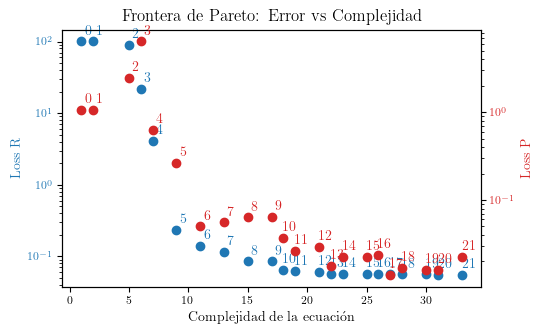

In [218]:
import matplotlib.pyplot as plt

# Obtener la complejidad y la puntuación (score) de cada ecuación
complejidades = equations_df['complexity']
errores_r = equations_df['loss']  # Por ejemplo, error MSE o cualquier métrica utilizada
errores_p = equations_df['P_error']  # Por ejemplo, error MSE o cualquier métrica utilizada

# Crear la figura y el eje
fig, ax1 = plt.subplots()

# Gráfico de errores_r en el eje izquierdo
color_r = 'tab:blue'
ax1.set_xlabel('Complejidad de la ecuación')
ax1.set_ylabel('Loss R', color=color_r)
ax1.scatter(complejidades, errores_r, color=color_r)
ax1.tick_params(axis='y', labelcolor=color_r)

# Añadir etiquetas de índice en cada punto (errores_r)
for i, (x, y) in enumerate(zip(complejidades, errores_r)):
    ax1.annotate(i, (x, y), textcoords="offset points", xytext=(5,5), ha='center', color=color_r)
plt.yscale('log')

# Crear un segundo eje y para los errores_p
ax2 = ax1.twinx()  # Crear un nuevo eje que comparte el mismo eje x
color_p = 'tab:red'
ax2.set_ylabel('Loss P', color=color_p)
ax2.scatter(complejidades, errores_p, color=color_p)
ax2.tick_params(axis='y', labelcolor=color_p)

# Añadir etiquetas de índice en cada punto (errores_p)
for i, (x, y) in enumerate(zip(complejidades, errores_p)):
    ax2.annotate(i, (x, y), textcoords="offset points", xytext=(5,5), ha='center', color=color_p)

# Añadir título
plt.title('Frontera de Pareto: Error vs Complejidad')
plt.yscale('log')
# Mostrar gráfico
plt.show()


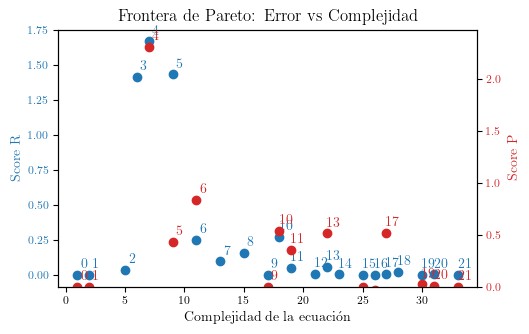

In [219]:
import matplotlib.pyplot as plt

# Obtener la complejidad y la puntuación (score) de cada ecuación
complejidades = equations_df['complexity']
score_r = equations_df['Score_r']  # Por ejemplo, error MSE o cualquier métrica utilizada
score_p = equations_df['Score_p']  # Por ejemplo, error MSE o cualquier métrica utilizada

# Crear la figura y el eje
fig, ax1 = plt.subplots()

# Gráfico de errores_r en el eje izquierdo
color_r = 'tab:blue'
ax1.set_xlabel('Complejidad de la ecuación')
ax1.set_ylabel('Score R', color=color_r)
ax1.scatter(complejidades, score_r, color=color_r)
ax1.tick_params(axis='y', labelcolor=color_r)

# Añadir etiquetas de índice en cada punto (errores_r)
for i, (x, y) in enumerate(zip(complejidades, score_r)):
    ax1.annotate(i, (x, y), textcoords="offset points", xytext=(5,5), ha='center', color=color_r)

# Crear un segundo eje y para los errores_p
ax2 = ax1.twinx()  # Crear un nuevo eje que comparte el mismo eje x
color_p = 'tab:red'
ax2.set_ylabel('Score P', color=color_p)
ax2.scatter(complejidades, score_p, color=color_p)
ax2.tick_params(axis='y', labelcolor=color_p)

# Añadir etiquetas de índice en cada punto (errores_p)
for i, (x, y) in enumerate(zip(complejidades, score_p)):
    ax2.annotate(i, (x, y), textcoords="offset points", xytext=(5,5), ha='center', color=color_p)

# Añadir título
plt.title('Frontera de Pareto: Error vs Complejidad')
plt.ylim(ymin=0)

# Mostrar gráfico
plt.show()


In [220]:
# Encontrar las tres filas con los menores valores en la columna 'P_error'
tres_menores_error_p = equations_df.nsmallest(3, 'P_error')

# Mostrar los resultados
print("Los tres menores valores de Error_P y sus índices:")
tres_menores_error_p


Los tres menores valores de Error_P y sus índices:


,complexity,loss,score,equation,sympy_format,lambda_format,P_error,Score_r,Score_p,Score_pr
17,27,0.056828,0.004407,(x0 + ((((225.58823 / ((exp(x0 * 75.08938) + 3...,(x0 + (225.58823/(exp(x0*75.08938) + 3.306483 ...,PySRFunction(X=>(x0 + (225.58823/(exp(x0*75.08...,0.014031,0.004407,0.516894,0.125245
20,31,0.055494,0.003083,((exp(3.2752414) * ((225.58908 / (((exp(x0 * 7...,(x0*x0 + (225.58908/(x0 + exp(x0*75.0743)*0.86...,PySRFunction(X=>(x0*x0 + (225.58908/(x0 + exp(...,0.016051,0.003083,0.006596,0.003747
19,30,0.055665,0.000144,((exp(3.2752414) * ((225.58908 / ((exp(x0 * 75...,(x0*x0 + (225.58908/(exp(x0*75.0743)*0.8629411...,PySRFunction(X=>(x0*x0 + (225.58908/(exp(x0*75...,0.016157,0.000144,0.021055,0.004765


In [198]:
equations_df.nsmallest(1, 'P_error').index[0]


17

In [240]:
choser=equations_df.nsmallest(1, 'P_error').index[0]
choser=9
expr=model_phi.sympy(choser)
expr
sympy.expand(expr)

47.8102638380502/(0.0425207924549065*exp(65.787895*x0) + 1)**0.5184029 - 0.36926335

In [241]:
sympy.factor(expr)


47.8102638380502*(1.0/(0.0425207924549065*exp(65.787895*x0) + 1)**0.5184029 - 0.00772351625690295)

In [242]:
sympy.simplify(expr)


47.8102638380502/(0.0425207924549065*exp(65.787895*x0) + 1)**0.5184029 - 0.36926335

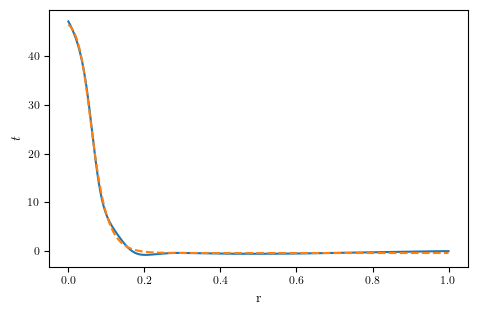

In [243]:
symb1=model_phi.predict(T_star_tf,choser)
# symb1=model_phi.predict(tf.concat([p,T_star_tf], axis=1),choser)

plt.plot(T_star_tf, r, label='PINN prediction')
plt.plot(T_star_tf, symb1, linestyle='--', label='Symbolic regresion')

plt.xlabel('r')
plt.ylabel('$t$')
plt.show()

In [244]:
Nt=10000
P_symb=np.zeros(Nt)
T_symb=np.zeros(Nt)
R_symb=np.zeros(Nt)

dt=0.0001

P_symb[0]=np.array(p[0]) #Initial conditions
# S_symb[0]=np.array(tf.exp(u_pred[0,1:2])) #Initial conditions
T_symb[0]=0
for i in range(1,Nt):
    T_symb[i]=T_symb[i-1]+dt

R_symb=model_phi.predict(T_symb.reshape([-1,1]),choser)
for i in range(1,Nt):
    P_symb[i]=P_symb[i-1]+R_symb[i-1]*P_symb[i-1]*dt
    T_symb[i]=T_symb[i-1]+dt

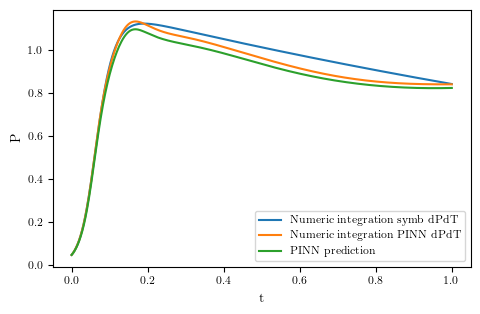

In [245]:
plt.plot(T_symb, P_symb, label='Numeric integration symb dPdT')
plt.plot(T_int, P_int, label='Numeric integration PINN dPdT')
plt.plot(T_star_tf, p, label='PINN prediction')
plt.xlabel('t')
plt.ylabel('P')
plt.legend()
plt.show()